In [1]:
import pandas as pd
from datetime import datetime as dt

In [2]:
us_wildfires = pd.read_csv('us_wildfires_filled.csv')

In [3]:
us_wildfires['DISCOVERY_DATE'] = pd.to_datetime(us_wildfires["DISCOVERY_DATE"], format = "%Y-%m-%d")
us_wildfires['CONT_DATE'] = pd.to_datetime(us_wildfires["CONT_DATE"], format = "%Y-%m-%d")

In [4]:
us_wildfires.isna().sum()

OBJECTID                     0
NWCG_REPORTING_AGENCY        0
NWCG_REPORTING_UNIT_ID       0
FIRE_NAME                    0
FIRE_YEAR                    0
DISCOVERY_DATE               0
NWCG_CAUSE_CLASSIFICATION    0
NWCG_GENERAL_CAUSE           0
NWCG_CAUSE_AGE_CATEGORY      0
CONT_DATE                    0
FIRE_SIZE                    0
FIRE_SIZE_CLASS              0
LATITUDE                     0
LONGITUDE                    0
OWNER_DESCR                  0
DURATION                     0
COUNTY                       0
STATE                        0
PRECIPITATION                0
TEMPERATURE                  0
WIND_SPEED                   0
ELEVATION                    0
dtype: int64

In [5]:
to_drop = ['OBJECTID', 'LATITUDE', 'LONGITUDE', 'FIRE_NAME']
model_data = us_wildfires.drop(to_drop, axis=1)

In [6]:
model_data['DAY_OF_WEEK'] = model_data['DISCOVERY_DATE'].dt.dayofweek

In [7]:
model_data['DAY_OF_YEAR'] = model_data['DISCOVERY_DATE'].dt.dayofyear

In [8]:
date_drop = ['DISCOVERY_DATE', 'CONT_DATE']
model_data = model_data.drop(model_data[date_drop], axis=1)

In [9]:
more_drops = ['NWCG_REPORTING_UNIT_ID', 'FIRE_SIZE_CLASS',
             'NWCG_CAUSE_CLASSIFICATION', 'NWCG_CAUSE_AGE_CATEGORY']
model_data = model_data.drop(more_drops, axis=1)

In [10]:
model_data['COUNTY_STATE'] = model_data['COUNTY'] + str(" ") + model_data['STATE']

In [11]:
model_data[['COUNTY_STATE', 'COUNTY', 'STATE']].head()

,COUNTY_STATE,COUNTY,STATE
0,Plumas County CA,Plumas County,CA
1,El Dorado County CA,El Dorado County,CA
2,Placer County CA,Placer County,CA
3,Alpine County CA,Alpine County,CA
4,Alpine County CA,Alpine County,CA


In [12]:
model_data = model_data.drop('COUNTY', axis=1)

In [13]:
model_data.columns.to_list()

['NWCG_REPORTING_AGENCY',
 'FIRE_YEAR',
 'NWCG_GENERAL_CAUSE',
 'FIRE_SIZE',
 'OWNER_DESCR',
 'DURATION',
 'STATE',
 'PRECIPITATION',
 'TEMPERATURE',
 'WIND_SPEED',
 'ELEVATION',
 'DAY_OF_WEEK',
 'DAY_OF_YEAR',
 'COUNTY_STATE']

In [14]:
model_data['COUNTY_STATE'] = model_data['COUNTY_STATE'].astype('category')
model_data['COUNTY_STATE'] = model_data['COUNTY_STATE'].cat.codes.astype(int)

In [15]:
model_data['STATE'] = model_data['STATE'].astype('category')
model_data['STATE'] = model_data['STATE'].cat.codes.astype(int)

In [16]:
model_data['NWCG_REPORTING_AGENCY'] = model_data['NWCG_REPORTING_AGENCY'].astype('category')
model_data['NWCG_REPORTING_AGENCY'] = model_data['NWCG_REPORTING_AGENCY'].cat.codes.astype(int)

In [17]:
model_data['OWNER_DESCR'] = model_data['OWNER_DESCR'].astype('category')
model_data['OWNER_DESCR'] = model_data['OWNER_DESCR'].cat.codes.astype(int)

# Running a random forest again

Using all data as usual, combining 'other' with 'undetermined', have dropped cause_age and cause_category

In [18]:
from sklearn import tree

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
#from imblearn.under_sampling import RandomUnderSampler
import time

In [19]:
model_data['NWCG_GENERAL_CAUSE'] = model_data['NWCG_GENERAL_CAUSE'].replace({'Other causes': 'Undetermined',
                                                                             'Undetermined': 'Undetermined'})

In [27]:
X1 = model_data.drop("NWCG_GENERAL_CAUSE", axis=1)
y1 = model_data["NWCG_GENERAL_CAUSE"]


X1_train, X1_test, y1_train, y1_test = train_test_split(X1,y1, test_size=0.2, shuffle=True, random_state=2)

In [28]:
dt1 = DecisionTreeClassifier()
dt1.fit(X1_train,y1_train)
dt1_predictions = dt1.predict(X1_test)
dt1_acc = accuracy_score(y1_test, dt1_predictions)
print(f"Decision Tree Accuracy Score: {dt1_acc}")

Decision Tree Accuracy Score: 0.4742962947552375


In [29]:
start_time = time.time()

rf1 = RandomForestClassifier()
rf1.fit(X1_train, y1_train)
rf1_predictions = rf1.predict(X1_test)
rf1_acc = accuracy_score(y1_test, rf1_predictions)
print(f"Random Forest Accuracy Score: {rf1_acc}")

print("--- %s seconds ---" % round(time.time() - start_time, 2))

Random Forest Accuracy Score: 0.5784752830126996
--- 998.36 seconds ---


In [30]:
report = classification_report(y1_test, rf1_predictions, output_dict=True)
report_df = pd.DataFrame(report).transpose()

In [31]:
report_df

,precision,recall,f1-score,support
Arson,0.537909,0.467349,0.500153,43751.000000
Debris and open burning,0.539827,0.706374,0.611972,81638.000000
Equipment and vehicle use,0.413102,0.244886,0.307491,28352.000000
Firearms and explosives use,0.795181,0.390533,0.523810,507.000000
Fireworks,0.592817,0.386544,0.467958,3032.000000
Misuse of fire by a minor,0.307094,0.110786,0.162831,8557.000000
Natural,0.753851,0.814944,0.783208,46359.000000
Power supply,0.367046,0.092427,0.147669,5929.000000
Railroad operations and maintenance,0.584335,0.370468,0.453449,3806.000000
Recreation and ceremony,0.504584,0.337349,0.404357,14030.000000


In [32]:
feature_importances = pd.DataFrame(
    rf1.feature_importances_, 
    index =X1_train.columns,  
    columns=['importance']
).sort_values('importance', ascending=False)

feature_importances

,importance
TEMPERATURE,0.115435
DAY_OF_YEAR,0.114356
ELEVATION,0.114330
WIND_SPEED,0.105975
FIRE_SIZE,0.092721
FIRE_YEAR,0.082332
COUNTY_STATE,0.079470
PRECIPITATION,0.078166
STATE,0.076163
DAY_OF_WEEK,0.055164


# Random Forest Dataset 2

data with OWNER_DESCR and NWCG_REPORTING_AGENCY removed

In [21]:
data_2 = model_data.drop(['OWNER_DESCR','NWCG_REPORTING_AGENCY'], axis=1)

In [22]:
X2 = data_2.drop("NWCG_GENERAL_CAUSE", axis=1)
y2 = data_2["NWCG_GENERAL_CAUSE"]


X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y2, test_size=0.2, shuffle=True, random_state=2)

In [23]:
dt2 = DecisionTreeClassifier()
dt2.fit(X2_train,y2_train)
dt2_predictions = dt2.predict(X2_test)
dt2_acc = accuracy_score(y2_test, dt2_predictions)
print(f"Decision Tree Accuracy Score: {dt2_acc}")

Decision Tree Accuracy Score: 0.4577212165162318


In [25]:
start_time = time.time()

rf2 = RandomForestClassifier()
rf2.fit(X2_train, y2_train)
rf2_predictions = rf2.predict(X2_test)
rf2_acc = accuracy_score(y2_test, rf2_predictions)
rf2_f1 = f1_score(y2_test, rf2_predictions, average='weighted')
print(f"Random Forest Accuracy Score: {rf2_acc}, F1-Score: {rf2_f1}")


print("--- %s seconds ---" % round(time.time() - start_time, 2))

Random Forest Accuracy Score: 0.5571984343282739
--- 1500.71 seconds ---


In [35]:
from sklearn.metrics import f1_score
rf2_f1 = f1_score(y2_test, rf2_predictions, average='micro')

In [36]:
rf2_f1

0.5571984343282739

In [26]:
report = classification_report(y2_test, rf2_predictions, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Arson,0.516076,0.446116,0.478552,43751.000000
Debris and open burning,0.524270,0.685330,0.594077,81638.000000
Equipment and vehicle use,0.379652,0.217304,0.276402,28352.000000
Firearms and explosives use,0.727273,0.347140,0.469960,507.000000
Fireworks,0.577509,0.362467,0.445390,3032.000000
Misuse of fire by a minor,0.276307,0.097581,0.144227,8557.000000
Natural,0.729408,0.807071,0.766277,46359.000000
Power supply,0.342986,0.089897,0.142456,5929.000000
Railroad operations and maintenance,0.565036,0.354966,0.436017,3806.000000
Recreation and ceremony,0.437706,0.255167,0.322392,14030.000000


In [27]:
feature_importances2 = pd.DataFrame(
    rf2.feature_importances_, 
    index =X2_train.columns,  
    columns=['importance']
).sort_values('importance', ascending=False)

feature_importances2

,importance
ELEVATION,0.125458
DAY_OF_YEAR,0.122767
TEMPERATURE,0.122409
WIND_SPEED,0.113483
FIRE_SIZE,0.100095
FIRE_YEAR,0.085754
COUNTY_STATE,0.084383
STATE,0.082729
PRECIPITATION,0.081548
DAY_OF_WEEK,0.057903


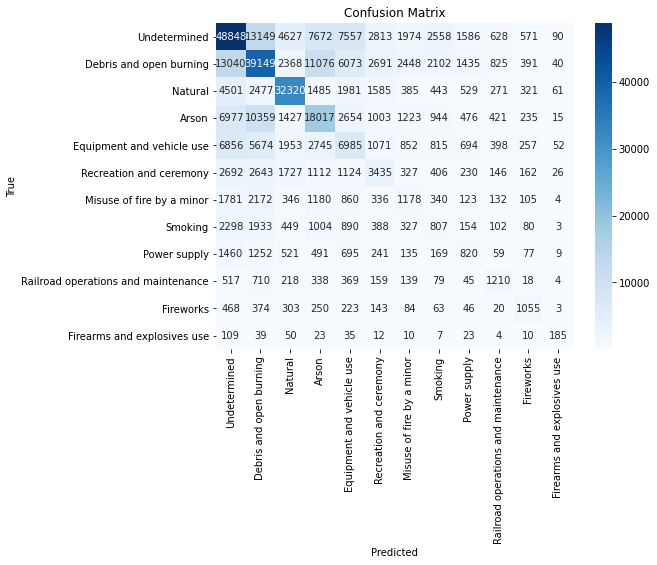

In [42]:
# Make a correlation matrix 
labels = y2_test.value_counts().index
cm = confusion_matrix(y2_test, dt2_predictions, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [20]:
# Creating dataset 2 - removing undetermined and combining other categories
data_2 = model_data.drop(['OWNER_DESCR','NWCG_REPORTING_AGENCY'], axis=1)
data_3 = data_2[data_2['NWCG_GENERAL_CAUSE']!= 'Undetermined']

# Combining Railroad, Power & Equipment/Vehicle
# data_3['NWCG_GENERAL_CAUSE'] = data_3['NWCG_GENERAL_CAUSE'].replace({'Railroad operations and maintenance': 'Infrastructure-related causes',
#                                                                           'Power supply': 'Infrastructure-related causes',
#                                                                           'Equipment and vehicle use': 'Infrastructure-related causes'})

# I am going to drop 'firearms & explosives use' as they don't fit exactly
# into another category, and there's so relatively few of them
# data_2 = data_2[data_2['NWCG_GENERAL_CAUSE']!='Firearms and explosives use']

# Combining FIreworks with Recreation & Ceremony
# data_2['NWCG_GENERAL_CAUSE'] = data_2['NWCG_GENERAL_CAUSE'].replace({'Fireworks': 'Recreation and ceremony'})


In [21]:
X3 = data_3.drop("NWCG_GENERAL_CAUSE", axis=1)
y3 = data_3["NWCG_GENERAL_CAUSE"]


X3_train, X3_test, y3_train, y3_test = train_test_split(X3,y3, test_size=0.2, shuffle=True, random_state=2)

In [24]:
dt3 = DecisionTreeClassifier()
dt3.fit(X3_train,y3_train)
dt3_predictions = dt3.predict(X3_test)
dt3_acc = accuracy_score(y3_test, dt3_predictions)
dt3_f1 = f1_score(y3_test, dt3_predictions, average='micro')
print(f"Decision Tree Accuracy Score: {dt3_acc}, f1 Score: {dt3_f1}")

Decision Tree Accuracy Score: 0.4862473631392467, f1 Score: 0.4862473631392467


In [25]:
start_time = time.time()

rf3 = RandomForestClassifier()
rf3.fit(X3_train, y3_train)
rf3_predictions = rf3.predict(X3_test)
rf3_acc = accuracy_score(y3_test, rf3_predictions)
rf3_f1 = f1_score(y3_test, rf3_predictions, average='weighted')
print(f"Random Forest Accuracy Score: {rf3_acc}, F1-Score: {rf3_f1}")


print("--- %s seconds ---" % round(time.time() - start_time, 2))

Random Forest Accuracy Score: 0.5940893358182973, F1-Score: 0.5686397349839172
--- 709.05 seconds ---


In [27]:
report3 = classification_report(y3_test, rf3_predictions, output_dict=True)
report3_df = pd.DataFrame(report3).transpose()
report3_df

,precision,recall,f1-score,support
Arson,0.550083,0.520245,0.534748,43987.000000
Debris and open burning,0.584213,0.781120,0.668468,81081.000000
Equipment and vehicle use,0.460294,0.357428,0.402391,28347.000000
Firearms and explosives use,0.795652,0.386076,0.519886,474.000000
Fireworks,0.630754,0.401223,0.490462,3108.000000
Misuse of fire by a minor,0.313826,0.108998,0.161800,8413.000000
Natural,0.764095,0.839383,0.799971,46533.000000
Power supply,0.414861,0.114549,0.179528,5849.000000
Railroad operations and maintenance,0.617556,0.354072,0.450088,3954.000000
Recreation and ceremony,0.481964,0.318609,0.383621,13923.000000


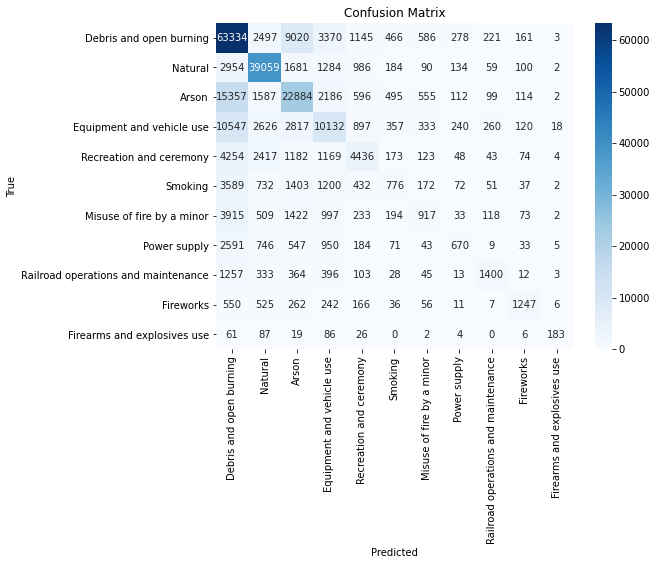

In [28]:
# Make a correlation matrix 
labels = y3_test.value_counts().index
cm = confusion_matrix(y3_test, rf3_predictions, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [29]:
# Creating dataset 4 - removing undetermined and combining other categories
data_2 = model_data.drop(['OWNER_DESCR','NWCG_REPORTING_AGENCY'], axis=1)
data_4 = data_2[data_2['NWCG_GENERAL_CAUSE']!= 'Undetermined']

# Combining Railroad, Power & Equipment/Vehicle
data_4['NWCG_GENERAL_CAUSE'] = data_4['NWCG_GENERAL_CAUSE'].replace({'Railroad operations and maintenance': 'Infrastructure-related causes',
                                                                          'Power supply': 'Infrastructure-related causes',
                                                                          'Equipment and vehicle use': 'Infrastructure-related causes'})


<ipython-input-29-268da25a12fa>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_4['NWCG_GENERAL_CAUSE'] = data_4['NWCG_GENERAL_CAUSE'].replace({'Railroad operations and maintenance': 'Infrastructure-related causes',


In [30]:
data_4['NWCG_GENERAL_CAUSE'].value_counts()

Debris and open burning          405877
Natural                          231547
Arson                            219102
Infrastructure-related causes    190808
Recreation and ceremony           69984
Misuse of fire by a minor         43018
Smoking                           42540
Fireworks                         15376
Firearms and explosives use        2423
Name: NWCG_GENERAL_CAUSE, dtype: int64

In [31]:
X4 = data_4.drop("NWCG_GENERAL_CAUSE", axis=1)
y4 = data_4["NWCG_GENERAL_CAUSE"]


X4_train, X4_test, y4_train, y4_test = train_test_split(X4,y4, test_size=0.2, shuffle=True, random_state=2)

In [32]:
dt4 = DecisionTreeClassifier()
dt4.fit(X4_train,y4_train)
dt4_predictions = dt4.predict(X4_test)
dt4_acc = accuracy_score(y4_test, dt4_predictions)
dt4_f1 = f1_score(y4_test, dt4_predictions, average='micro')
print(f"Decision Tree Accuracy Score: {dt4_acc}, f1 Score: {dt4_f1}")

Decision Tree Accuracy Score: 0.49952690109980136, f1 Score: 0.49952690109980136


In [33]:
start_time = time.time()

rf4 = RandomForestClassifier()
rf4.fit(X4_train, y4_train)
rf4_predictions = rf4.predict(X4_test)
rf4_acc = accuracy_score(y4_test, rf4_predictions)
rf4_f1 = f1_score(y4_test, rf4_predictions, average='weighted')
print(f"Random Forest Accuracy Score: {rf4_acc}, F1-Score: {rf4_f1}")


print("--- %s seconds ---" % round(time.time() - start_time, 2))

Random Forest Accuracy Score: 0.6030229176480226, F1-Score: 0.5826990299308966
--- 629.42 seconds ---


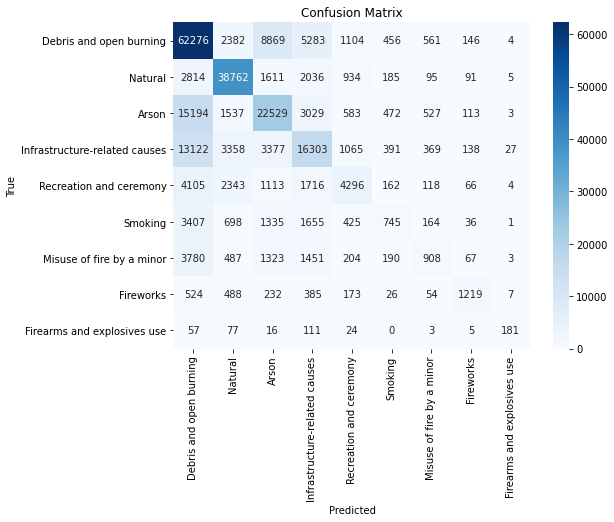

In [34]:
# Make a correlation matrix 
labels = y4_test.value_counts().index
cm = confusion_matrix(y4_test, rf4_predictions, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [20]:
# Dataset 5 - above but with 'eratic' category of minor & smoking

data_2 = model_data.drop(['OWNER_DESCR','NWCG_REPORTING_AGENCY'], axis=1)
data_5 = data_2[data_2['NWCG_GENERAL_CAUSE']!= 'Undetermined']


data_5['NWCG_GENERAL_CAUSE'] = data_5['NWCG_GENERAL_CAUSE'].replace({'Railroad operations and maintenance': 'Infrastructure-related causes',
                                                                          'Power supply': 'Infrastructure-related causes',
                                                                          'Equipment and vehicle use': 'Infrastructure-related causes'})
data_5['NWCG_GENERAL_CAUSE'] = data_5['NWCG_GENERAL_CAUSE'].replace({'Smoking': 'Erratic',
                                                                     'Misuse of fire by a minor': 'Erratic'})


<ipython-input-20-2362b542aa21>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_5['NWCG_GENERAL_CAUSE'] = data_5['NWCG_GENERAL_CAUSE'].replace({'Railroad operations and maintenance': 'Infrastructure-related causes',
<ipython-input-20-2362b542aa21>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_5['NWCG_GENERAL_CAUSE'] = data_5['NWCG_GENERAL_CAUSE'].replace({'Smoking': 'Erratic',


In [24]:
data_5['NWCG_GENERAL_CAUSE'].value_counts()

Debris and open burning          405877
Natural                          231547
Arson                            219102
Infrastructure-related causes    190808
Erratic                           85558
Recreation and ceremony           69984
Fireworks                         15376
Firearms and explosives use        2423
Name: NWCG_GENERAL_CAUSE, dtype: int64

In [21]:
data_5.to_csv('final_data.csv', index=False)

In [25]:
X5 = data_5.drop("NWCG_GENERAL_CAUSE", axis=1)
y5 = data_5["NWCG_GENERAL_CAUSE"]


X5_train, X5_test, y5_train, y5_test = train_test_split(X5,y5, test_size=0.2, shuffle=True, random_state=2)

In [49]:
dt5 = DecisionTreeClassifier()
dt5.fit(X5_train,y5_train)
dt5_predictions = dt5.predict(X5_test)
dt5_acc = accuracy_score(y5_test, dt5_predictions)
dt5_f1 = f1_score(y5_test, dt5_predictions, average='micro')
print(f"Decision Tree Accuracy Score: {dt5_acc}, f1 Score: {dt5_f1}")

Decision Tree Accuracy Score: 0.5021606897822926, f1 Score: 0.5021606897822926


In [50]:
start_time = time.time()

rf5 = RandomForestClassifier()
rf5.fit(X5_train, y5_train)
rf5_predictions = rf5.predict(X5_test)
rf5_acc = accuracy_score(y5_test, rf5_predictions)
rf5_f1 = f1_score(y5_test, rf5_predictions, average='weighted')
print(f"Random Forest Accuracy Score: {rf5_acc}, F1-Score: {rf5_f1}")


print("--- %s seconds ---" % round(time.time() - start_time, 2))

Random Forest Accuracy Score: 0.6045794335101481, F1-Score: 0.5871579684560867
--- 629.58 seconds ---


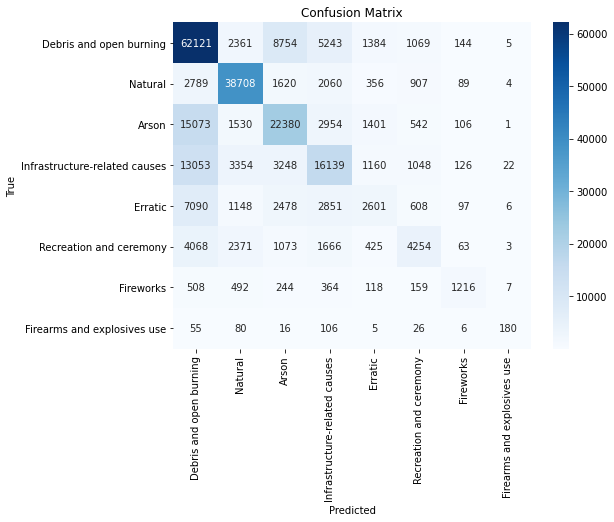

In [51]:
# Make a correlation matrix 
labels = y5_test.value_counts().index
cm = confusion_matrix(y5_test, rf5_predictions, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [26]:
# Dataset 6 - dataset 5 but oversampled 

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X5_resampled, y5_resampled = ros.fit_resample(X5, y5)

In [27]:
X6_train, X6_test, y6_train, y6_test = train_test_split(X5_resampled,y5_resampled, test_size=0.2, shuffle=True, random_state=2)

In [28]:
dt6 = DecisionTreeClassifier()
dt6.fit(X6_train,y6_train)
dt6_predictions = dt6.predict(X6_test)
dt6_acc = accuracy_score(y6_test, dt6_predictions)
dt6_f1 = f1_score(y6_test, dt6_predictions, average='micro')
print(f"Decision Tree Accuracy Score: {dt6_acc}, f1 Score: {dt6_f1}")

Decision Tree Accuracy Score: 0.8752594686820531, f1 Score: 0.8752594686820531


In [29]:
start_time = time.time()

rf6 = RandomForestClassifier()
rf6.fit(X6_train, y6_train)
rf6_predictions = rf6.predict(X6_test)
rf6_acc = accuracy_score(y6_test, rf6_predictions)
rf6_f1 = f1_score(y6_test, rf6_predictions, average='weighted')
print(f"Random Forest Accuracy Score: {rf6_acc}, F1-Score: {rf6_f1}")


print("--- %s seconds ---" % round(time.time() - start_time, 2))

Random Forest Accuracy Score: 0.9044924269022057, F1-Score: 0.9023806797172509
--- 2085.74 seconds ---


In [30]:
undetermined_data = data_2[data_2['NWCG_GENERAL_CAUSE']== 'Undetermined']
undetermined_model = undetermined_data.drop("NWCG_GENERAL_CAUSE", axis=1)

undetermined_predicts = rf6.predict(undetermined_model)

In [35]:
ut_predicts = pd.DataFrame(undetermined_predicts)

In [37]:
ut_predicts.value_counts()

Debris and open burning          130160
Infrastructure-related causes    105754
Arson                             91756
Erratic                           53646
Natural                           45458
Recreation and ceremony           30492
Fireworks                          3887
Firearms and explosives use         513
dtype: int64

In [43]:
y5_train.value_counts() + y5_test.value_counts()

Debris and open burning          405877
Natural                          231547
Arson                            219102
Infrastructure-related causes    190808
Erratic                           85558
Recreation and ceremony           69984
Fireworks                         15376
Firearms and explosives use        2423
Name: NWCG_GENERAL_CAUSE, dtype: int64

In [38]:
ut_predicts.to_csv("undetermined_predictions.csv", index=False)

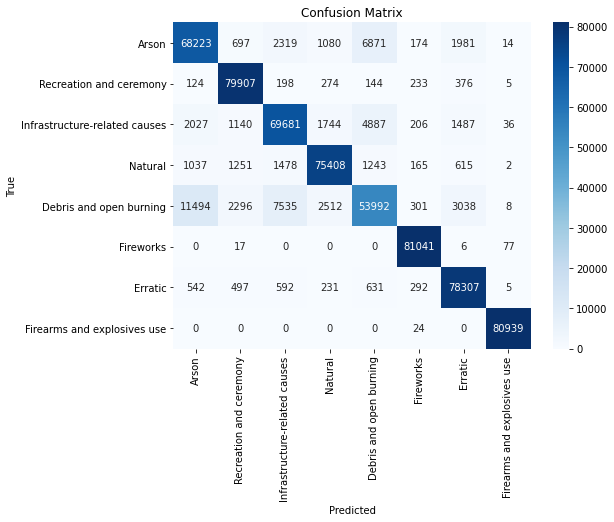

In [27]:
# Make a correlation matrix 
labels = y6_test.value_counts().index
cm = confusion_matrix(y6_test, rf6_predictions, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [28]:
report6 = classification_report(y6_test, rf6_predictions, output_dict=True)
report6_df = pd.DataFrame(report6).transpose()
report6_df

,precision,recall,f1-score,support
Arson,0.817561,0.838543,0.827919,81359.000000
Debris and open burning,0.796718,0.665123,0.724997,81176.000000
Erratic,0.912563,0.965597,0.938331,81097.000000
Firearms and explosives use,0.998187,0.999704,0.998945,80963.000000
Fireworks,0.983078,0.998768,0.990861,81141.000000
Infrastructure-related causes,0.851815,0.858056,0.854924,81208.000000
Natural,0.928110,0.928681,0.928396,81199.000000
Recreation and ceremony,0.931263,0.983338,0.956592,81261.000000
accuracy,0.904673,0.904673,0.904673,0.904673
macro avg,0.902412,0.904726,0.902620,649404.000000


In [29]:
feature_importances6 = pd.DataFrame(
    rf6.feature_importances_, 
    index =X6_train.columns,  
    columns=['importance']
).sort_values('importance', ascending=False)

feature_importances6

,importance
DAY_OF_YEAR,0.137420
ELEVATION,0.133737
COUNTY_STATE,0.116924
TEMPERATURE,0.113878
WIND_SPEED,0.102382
FIRE_SIZE,0.091657
PRECIPITATION,0.078139
FIRE_YEAR,0.077994
STATE,0.077543
DAY_OF_WEEK,0.049875


In [31]:
# Dataset 7

data_7 = data_5
data_7['NWCG_GENERAL_CAUSE'] = data_7['NWCG_GENERAL_CAUSE'].replace({'Arson': 'Intentional Fires',
                                                                     'Debris and open burning': 'Intentional Fires'})

<ipython-input-31-3672500cc7d7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_7['NWCG_GENERAL_CAUSE'] = data_7['NWCG_GENERAL_CAUSE'].replace({'Arson': 'Intentional Fires',


In [32]:
data_7['NWCG_GENERAL_CAUSE'].value_counts()

Intentional Fires                624979
Natural                          231547
Infrastructure-related causes    190808
Erratic                           85558
Recreation and ceremony           69984
Fireworks                         15376
Firearms and explosives use        2423
Name: NWCG_GENERAL_CAUSE, dtype: int64

In [33]:
X7 = data_7.drop("NWCG_GENERAL_CAUSE", axis=1)
y7 = data_7["NWCG_GENERAL_CAUSE"]
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X7_resampled, y7_resampled = ros.fit_resample(X7, y7)

In [34]:

X7_train, X7_test, y7_train, y7_test = train_test_split(X7,y7, test_size=0.2, shuffle=True, random_state=2)

In [35]:
dt7 = DecisionTreeClassifier()
dt7.fit(X7_train,y7_train)
dt7_predictions = dt7.predict(X7_test)
dt7_acc = accuracy_score(y7_test, dt7_predictions)
dt7_f1 = f1_score(y7_test, dt7_predictions, average='micro')
print(f"Decision Tree Accuracy Score: {dt7_acc}, f1 Score: {dt7_f1}")

Decision Tree Accuracy Score: 0.5993855858438979, f1 Score: 0.5993855858438979


In [ ]:
# Testing a graph for Ana

In [44]:
import seaborn as sns

In [55]:
# Group by FIRE_YEAR and sum the FIRE_SIZE column
acres_burnt_per_year = model_data.groupby('FIRE_YEAR')['FIRE_SIZE'].sum().reset_index()

acres_burnt_per_year.columns = ['FIRE_YEAR', 'Total Acres Burnt']

# acres_burnt_per_year = acres_burnt_per_year.sort_values(by='FIRE_YEAR', ascending=True)

# # Make 'FIRE_YEAR' the index of the DataFrame
# acres_burnt_per_year.set_index('FIRE_YEAR', inplace=True)

In [51]:
# acres_burnt_per_year['Total Acres Burnt'] = acres_burnt_per_year['Total Acres Burnt'] / 1e6  # Convert from millions to regular units
# acres_burnt_per_year['Total Acres Burnt'] = acres_burnt_per_year['Total Acres Burnt'].apply(lambda x: "{:.3f}".format(x))  # Format values with 3 decimal places


In [52]:
acres_burnt_per_year

,FIRE_YEAR,Total Acres Burnt
0,2000,7.013
1,2001,3.598
2,2002,4.629
3,2003,3.865
4,2004,1.643
5,2005,5.001
6,2006,9.799
7,2007,8.579
8,2008,5.326
9,2009,3.124


NameError: name 'ax' is not defined

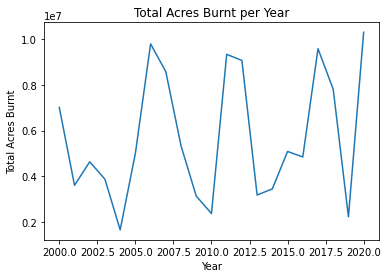

In [62]:
# Plotting the time series graph
#plt.figure(figsize=(20, 8))
plt.plot(acres_burnt_per_year['FIRE_YEAR'], acres_burnt_per_year['Total Acres Burnt'])

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Total Acres Burnt')
plt.title('Total Acres Burnt per Year')
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x/1000) + 'K'))

# Manually setting the limits of the y-axis
#plt.ylim(1, 11)

# Show plot
plt.grid(False)
plt.show()